# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from PIL import Image
import site
import numpy as np
import os
import sys
import tarfile
from IPython.display import display
from IPython.display import Image as image2
#from PIL import Image
from scipy import ndimage
from os.path import isfile, join
import h5py

from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import tensorflow as tf


In [ ]:
from dataprep import *

In [2]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 188400437


In [8]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save 
    
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)

  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (40000, 28, 28, 1) (40000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [6]:
batch_size = 128
hidden_nodes = 1024
learning_rate = 0.07

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

graph = tf.Graph()
with graph.as_default():

    
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) 
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    weights_3 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    biases_3 = tf.Variable(tf.zeros([num_labels]))

    hidden1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    hidden2 = tf.nn.relu(hidden1)
    logits = tf.matmul(hidden2, weights_3) + biases_3
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + learning_rate*tf.nn.l2_loss(weights_1) + learning_rate*tf.nn.l2_loss(weights_3))

    #learning!
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    train_prediction = tf.nn.softmax(logits)
   
    valid1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    valid2 = tf.nn.relu(valid1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid2, weights_3) + biases_3)
    test1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    test2 = tf.nn.relu(test1)
    test_prediction = tf.nn.softmax(tf.matmul(test2, weights_3) + biases_3)

num_steps = 3001
data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    #tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):

        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % batch_score)
            print("Validation accuracy: %.1f%%" % valid_score)
    print("Test accuracy: %.1f%%" % test_score)

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()

Initialized
Minibatch loss at step 0: 22281.150391
Minibatch accuracy: 12.5%
Validation accuracy: 24.2%
Minibatch loss at step 100: 8230.445312
Minibatch accuracy: 77.3%
Validation accuracy: 74.3%
Minibatch loss at step 200: 3077.817871
Minibatch accuracy: 81.2%
Validation accuracy: 78.5%
Minibatch loss at step 300: 1150.476074
Minibatch accuracy: 86.7%
Validation accuracy: 78.7%
Minibatch loss at step 400: 430.710663
Minibatch accuracy: 82.8%
Validation accuracy: 80.5%
Minibatch loss at step 500: 161.633606
Minibatch accuracy: 85.2%
Validation accuracy: 82.9%
Minibatch loss at step 600: 61.094181
Minibatch accuracy: 82.8%
Validation accuracy: 82.8%
Minibatch loss at step 700: 23.682022
Minibatch accuracy: 78.9%
Validation accuracy: 81.8%
Minibatch loss at step 800: 9.615603
Minibatch accuracy: 82.0%
Validation accuracy: 80.9%
Minibatch loss at step 900: 4.521854
Minibatch accuracy: 73.4%
Validation accuracy: 80.8%
Minibatch loss at step 1000: 2.414463
Minibatch accuracy: 81.2%
Validat

### Question 1
_What approach did you take in coming up with a solution to this problem?_

The underlying data set is notmnist numbers. The training sample size was set to 60.000.
The udacity exercise 1_notmnist approach was borrowed to load and format the data into a pickle.

I then applied a neural network with two hidden layers and relu activation functions.
The test accuracy of 89.2% was obtained by reducing the learning rate from 0.5 to 0.07 and by setting the training steps to 3001, since performance tapered off here.

The second hidden layer also also been supplied with a nonlinearity: Initially, a sigmoid activation function has been set, but relus performed better by a 2-4% margin and thus remained in the model

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

We have a neural network with 2 hidden layers, the actuation function is set to rectified linear units at each layer.
I modified the learning rate with different attempts of setting it to 0.5, 0.01 and ultimately 0.1.
and the learning steps were initially set to 1000, then to 3000.This helped to increase test accuracy from 85% to near 90%. Performance tapered off near 3000 iteration steps, additional steps were thus omitted.

The learning element of the network is implemented with a gradient descent optimizer and the prediction is derived by a softmax activation function.

Since each layer has their own weights and biases, their are maintained separate for each layer.






### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

The model was trained by feeding the training set in batches of 128, out of the 40.000 picture repository.
While we apply offset to create the batch, overlap between individual batches per training step is avoided.

Training the model involved identifying one digit per image, while the position of the digit within the digit was more or less within comparable ranges.

The synthetic dataset was created as introduced in the 1_notmnist documentation. Herek pictures have been transferred to a more easily machine readable format, a so called pickle, and some normalization techniques have been applied to enable more efficient gradient descent training.

Cropping or gray-scaling of the images was not applied since Not_Mnist provides more challenging data than MNIST but is relatively homogeneous (as opposed to SVHN)

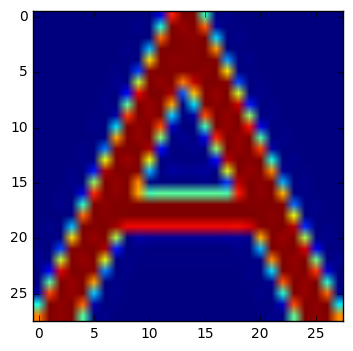

In [10]:
pickle_file = train_datasets[0]  # index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    plt.figure()
    plt.imshow(sample_image)  # display it

Step 2: Train a Model on a Realistic Dataset¶

Once you have settled on a good architecture, you can train your model on real data. In particular, the Street View House Numbers (SVHN) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
#####
#Due to different precondictions (format of raw data and bounding box data provision) and different machine learning tasks,
#such as finding the length of the number and the positions of the given digits, the approach taken below largely differs from
#the model introduced during NOT-MNIST above.
#####

In [143]:
###for preprocessing of svhn file please see svhn_prep.ipynb or *.html file###
svhn_file=h5py.File("SVHN.hdf5","r")
#print(svhn_file.keys())

train_dataset = svhn_file['train_dataset'][()]
#print(train_dataset.shape[0])
train_labels = svhn_file['train_labels'][()]
test_dataset = svhn_file['test_dataset'][()]
test_labels = svhn_file['test_labels'][()]
svhn_file.close()

###bad reformatting, see error below###

#train_dataset = train_dataset.astype(np.float32)
#train_labels = train_labels.astype(np.float32)
#test_dataset = test_dataset.astype(np.float32)
#test_labels = test_labels.astype(np.float32)

#ValueError: Shape must be rank 2 but is rank 4 for 'MatMul_2' (op: 'MatMul') with input shapes: [13068,32,32,3], [1024,1024].


[ 2  2  9 10 10 10]


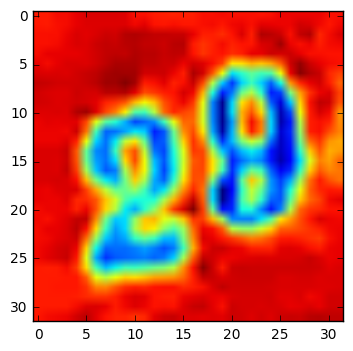

In [45]:
plt.imshow(train_dataset[100,:,:])
print(train_labels[100])


In [144]:
image_size = 32


def reshape(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    #setting this as float will cause problems
    labels = labels.astype(np.int32)
    return dataset, labels

train_dataset, train_labels = reshape(train_dataset, train_labels)
test_dataset, test_labels = reshape(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (33402, 1024) (33402, 6)
Test set (13068, 1024) (13068, 6)


In [151]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])
  #set to axis 1 , Transpose?
  #return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [152]:
#####very first implementation step not involving any layers and not considering that we have multiple digits per image###


batch_size = 128
num_labels = 6

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer adam works much better than gradient descent (higher average performance)

  #optimizer = tf.train.AdamOptimizer(0.5).minimize(loss)
  optimizer = tf.train.AdagradOptimizer(0.05).minimize(loss)
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [153]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Picking a random slice of the training data
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # and plugging it into a minibatch preparation
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # setting a dictionary up with the minibatch
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 5000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      #print(predictions)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1375.972900
Minibatch accuracy: 19.5%
Minibatch loss at step 5000: 1186.648438
Minibatch accuracy: 22.7%
Minibatch loss at step 10000: 1315.320190
Minibatch accuracy: 21.9%
Test accuracy: 23.7%


In [154]:
#new accuracy functions required to get a more detailed picture about performance and bottlenecks
#due to having 5 digits and 1 additional element (length of number)

def accuracy_single(predictions, labels):
    #argmax selecting the value with the highest probability
    a = np.argmax(predictions, 2).T == labels[:,1:6]
    length = labels[:,0]
    summ = 0.0
    for i in range(len(length)):
        summ += np.sum(a[i,:length[i]])
    return(100 * summ / np.sum(length))

def accuracy_multi(predictions, labels):
    count = predictions.shape[1]
    return 100.0 * (count - np.sum([1 for i in np.argmax(predictions, 2).T == labels[:,1:6] if False in i])) / count

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [156]:
####second iteration now considering different numbers of digits by giving each a logit for training####
###or would it be sensible to go deep first?###


batch_size = 128
num_hidden1 = 1024 #identical to image_size*image_size
num_labels = 11

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  #tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_labels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
  tf_test_dataset = tf.constant(test_dataset)

  #weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  #biases = tf.Variable(tf.zeros([num_labels]))


  
  ###each digit gets its own weight and bias here
  s1_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
  s1_b = tf.Variable(tf.ones([num_labels]))
    
  s2_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
  s2_b = tf.Variable(tf.ones([num_labels]))
  
  s3_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
  s3_b = tf.Variable(tf.ones([num_labels]))
    
  s4_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
  s4_b = tf.Variable(tf.ones([num_labels]))
    
  s5_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
  s5_b = tf.Variable(tf.ones([num_labels]))
  
 # not so convolutional yet
  def model(data):
    logits1 = tf.matmul(data, s1_w) + s1_b
    logits2 = tf.matmul(data, s2_w) + s2_b
    logits3 = tf.matmul(data, s3_w) + s3_b
    logits4 = tf.matmul(data, s4_w) + s4_b
    logits5 = tf.matmul(data, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]

  # Training computation.
  #for a single digit: logits = tf.matmul(tf_train_dataset, weights) + biases
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset)
     
  ####comparing the predicted value of each logit with the actual label to calculate losses
  #single digit: loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
  
  #loss reduction with adagrad
  optimizer = tf.train.AdagradOptimizer(0.03).minimize(loss)

  
  ####getting predictions from the logits###  
  def prediction(dataset):
    prediction = tf.pack([
        tf.nn.softmax(model(dataset)[0]),
        tf.nn.softmax(model(dataset)[1]),
        tf.nn.softmax(model(dataset)[2]),
        tf.nn.softmax(model(dataset)[3]),
        tf.nn.softmax(model(dataset)[4])])
    return prediction
    
    
  train_prediction = prediction(tf_train_dataset)
  test_prediction = prediction(tf_test_dataset)

In [157]:
num_steps = 50001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if (step % 5000 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
            
            print('Minibatch accuracy for single digit: %.1f%%' % accuracy_single(predictions, batch_labels))
            print('Minibatch accuracy for full picture: %.1f%%' % accuracy_multi(predictions, batch_labels))
            #print('prediction', predictions)
            #print('label', batch_labels[:,1:6])
            
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6])) 
    print('Test accuracy for single digit: %.1f%%' % accuracy_single(test_prediction.eval(), test_labels))
    print('Test accuracy for full picture: %.1f%%' % accuracy_multi(test_prediction.eval(), test_labels))




Initialized
Minibatch loss at step 0: 23.938599
Minibatch accuracy: 11.4%
Minibatch accuracy for single digit: 12.4%
Minibatch accuracy for full picture: 0.0%
Minibatch loss at step 5000: 5.625582
Minibatch accuracy: 64.7%
Minibatch accuracy for single digit: 22.0%
Minibatch accuracy for full picture: 7.8%
Minibatch loss at step 10000: 5.608036
Minibatch accuracy: 65.2%
Minibatch accuracy for single digit: 24.4%
Minibatch accuracy for full picture: 5.5%
Minibatch loss at step 15000: 5.538824
Minibatch accuracy: 66.9%
Minibatch accuracy for single digit: 25.8%
Minibatch accuracy for full picture: 7.8%
Minibatch loss at step 20000: 5.789656
Minibatch accuracy: 63.3%
Minibatch accuracy for single digit: 21.0%
Minibatch accuracy for full picture: 4.7%
Minibatch loss at step 25000: 5.410060
Minibatch accuracy: 67.2%
Minibatch accuracy for single digit: 26.3%
Minibatch accuracy for full picture: 7.8%
Minibatch loss at step 30000: 5.366522
Minibatch accuracy: 66.1%
Minibatch accuracy for sing

In [158]:
###third iteration considering a first attempt at adding more depth / layers ####
####results taper off - maybe too much noise in raw data or length of sentence/position of sentence not adequately 
####...considered without convolutions?


#pictures per training cycle
batch_size = 128
#nodes aka ?
num_hidden1 = 1024
#different meaning compared to reshaping function since we now look at the type of digit and not the position 
num_labels = 11

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  #tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_labels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
  tf_test_dataset = tf.constant(test_dataset)

  #weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  #biases = tf.Variable(tf.zeros([num_labels]))
    
    
  ###defining hidden layer 1 weights and biases outside the model (?)
  h1_w = tf.Variable(tf.truncated_normal([num_hidden1, batch_size]))
  h1_b = tf.Variable(tf.ones([batch_size]))

  ###defining hidden layer 2 as the one above makes performance worse!


  ###each logit gets its own weight and bias here
  s1_w = tf.Variable(tf.truncated_normal([batch_size, num_labels],stddev=0.1))
  s1_b = tf.Variable(tf.ones([num_labels]))
    
  s2_w = tf.Variable(tf.truncated_normal([batch_size, num_labels],stddev=0.1))
  s2_b = tf.Variable(tf.ones([num_labels]))
  
  s3_w = tf.Variable(tf.truncated_normal([batch_size, num_labels],stddev=0.1))
  s3_b = tf.Variable(tf.ones([num_labels]))
    
  s4_w = tf.Variable(tf.truncated_normal([batch_size, num_labels],stddev=0.1))
  s4_b = tf.Variable(tf.ones([num_labels]))
    
  s5_w = tf.Variable(tf.truncated_normal([batch_size, num_labels],stddev=0.1))
  s5_b = tf.Variable(tf.ones([num_labels]))
  


 #  def forward_prop(inp):
 #       h1 = tf.nn.relu(tf.matmul(inp, weights_1) + biases_1)
  #      return tf.matmul(h1,weights_2) + biases_2
    #logits = forward_prop(tf_train_dataset)

  ###expanded version for each logit
  def model(data):
    ###this piece of code is really awkward right now and needs to be refactored when functionality is proven
    ###see tensorflow for expert tutorials?
    hidden1 = tf.nn.relu(tf.matmul(data, h1_w) + h1_b)

    logits1 = tf.matmul(hidden1, s1_w) + s1_b
    logits2 = tf.matmul(hidden1, s2_w) + s2_b
    logits3 = tf.matmul(hidden1, s3_w) + s3_b
    logits4 = tf.matmul(hidden1, s4_w) + s4_b
    logits5 = tf.matmul(hidden1, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]

  # Training computation.
  #for a single digit: logits = tf.matmul(tf_train_dataset, weights) + biases
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset)
     
  ####comparing the predicted value of each logit with the actual label to calculate losses
  #single digit: loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
  
  #loss reduction with adagrad
  #optimizer = tf.train.AdagradOptimizer(0.05).minimize(loss)
  optimizer = tf.train.AdamOptimizer(0.5).minimize(loss)
  
  ####getting predictions from the logits###  
  #one prediction for each position###
  def prediction(dataset):
    prediction = tf.pack([
        tf.nn.softmax(model(dataset)[0]),
        tf.nn.softmax(model(dataset)[1]),
        tf.nn.softmax(model(dataset)[2]),
        tf.nn.softmax(model(dataset)[3]),
        tf.nn.softmax(model(dataset)[4])])
    return prediction
    
    
  train_prediction = prediction(tf_train_dataset)
  test_prediction = prediction(tf_test_dataset)

In [159]:
#keep number low - computationally heavy
num_steps = 50001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if (step % 5000 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
            print('Minibatch accuracy for single digit: %.1f%%' % accuracy_single(predictions, batch_labels))
            print('Minibatch accuracy for full picture: %.1f%%' % accuracy_multi(predictions, batch_labels))
            #print('prediction', predictions)
            #print('label', batch_labels[:,1:6])
            
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6])) 
    print('Test accuracy for single digit: %.1f%%' % accuracy_single(test_prediction.eval(), test_labels))
    print('Test accuracy for full picture: %.1f%%' % accuracy_multi(test_prediction.eval(), test_labels))



Initialized
Minibatch loss at step 0: 194.360367
Minibatch accuracy: 3.8%
Minibatch accuracy for single digit: 6.6%
Minibatch accuracy for full picture: 0.0%
Minibatch loss at step 5000: 6.726330
Minibatch accuracy: 62.0%
Minibatch accuracy for single digit: 20.5%
Minibatch accuracy for full picture: 2.3%
Minibatch loss at step 10000: 6.118676
Minibatch accuracy: 61.9%
Minibatch accuracy for single digit: 13.8%
Minibatch accuracy for full picture: 3.1%
Minibatch loss at step 15000: 5.998750
Minibatch accuracy: 60.8%
Minibatch accuracy for single digit: 17.5%
Minibatch accuracy for full picture: 0.8%
Minibatch loss at step 20000: 5.972455
Minibatch accuracy: 60.6%
Minibatch accuracy for single digit: 17.5%
Minibatch accuracy for full picture: 4.7%
Minibatch loss at step 25000: 5.982301
Minibatch accuracy: 61.4%
Minibatch accuracy for single digit: 17.9%
Minibatch accuracy for full picture: 0.0%
Minibatch loss at step 30000: 5.931665
Minibatch accuracy: 61.9%
Minibatch accuracy for singl

In [160]:
####restart with different approach

svhn_file=h5py.File("SVHN.hdf5","r")
#print(svhn_file.keys())

train_dataset = svhn_file['train_dataset'][()]
#print(train_dataset.shape[0])
train_labels = svhn_file['train_labels'][()]
test_dataset = svhn_file['test_dataset'][()]
test_labels = svhn_file['test_labels'][()]
svhn_file.close()

In [161]:
image_size = 32
num_channels = 1


def reshape(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size,num_channels)).astype(np.float32)
    #setting this as float will cause problems
    labels = labels.astype(np.int32)
    return dataset, labels

train_dataset, train_labels = reshape(train_dataset, train_labels)
test_dataset, test_labels = reshape(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (33402, 32, 32, 1) (33402, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [180]:
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64


graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
   # tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1],stddev=0.1))
    layer1_biases = tf.Variable(tf.ones([depth1]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2],stddev=0.1))
    layer2_biases = tf.Variable(tf.ones([depth2]))
    
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size,depth2, num_hidden1],stddev=0.1))
    layer3_biases = tf.Variable(tf.ones([num_hidden1]))
    

    s1_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
    s1_b = tf.Variable(tf.ones([num_labels]))
    
    s2_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
    s2_b = tf.Variable(tf.ones([num_labels]))
    
    s3_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
    s3_b = tf.Variable(tf.ones([num_labels]))
    
    s4_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
    s4_b = tf.Variable(tf.ones([num_labels]))
    
    s5_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
    s5_b = tf.Variable(tf.ones([num_labels]))
  
    # CNN
    def model(data, keep_prob=1):
        conv = tf.nn.conv2d(data,layer1_weights, [1,1,1,1],padding='VALID')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        pool = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        conv = tf.nn.conv2d(pool, layer2_weights, [1,1,1,1], padding='VALID')
        hidden = tf.nn.relu(conv + layer2_biases)
        #lrn = tf.nn.local_response_normalization(hidden)
        #pool = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        #conv = tf.nn.conv2d(pool, layer3_weights, [1,1,1,1], padding='VALID')
        #hidden = tf.nn.relu(conv + layer3_biases)
        #hidden = tf.nn.dropout(hidden, keep_prob)
        ##shape = hidden.get_shape().as_list()
       # reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        logits1 = tf.matmul(hidden, s1_w) + s1_b
        logits2 = tf.matmul(hidden, s2_w) + s2_b
        logits3 = tf.matmul(hidden, s3_w) + s3_b
        logits4 = tf.matmul(hidden, s4_w) + s4_b
        logits5 = tf.matmul(hidden, s5_w) + s5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9)
    # Define loss function.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
    #loss reduction with adagrad
    ###################this does the trick#####################
    optimizer = tf.train.AdagradOptimizer(0.05).minimize(loss)
    #optimizer = tf.train.AdamOptimizer(0.1).minimize(loss)
  
    ####getting predictions from the logits###  
    #one prediction for each position###
    def prediction(dataset):
      prediction = tf.pack([
        tf.nn.softmax(model(dataset)[0]),
        tf.nn.softmax(model(dataset)[1]),
        tf.nn.softmax(model(dataset)[2]),
        tf.nn.softmax(model(dataset)[3]),
        tf.nn.softmax(model(dataset)[4])])
      return prediction
    
    
    train_prediction = prediction(tf_train_dataset)
    test_prediction = prediction(tf_test_dataset)
    saver = tf.train.Saver()

ValueError: Shape must be rank 2 but is rank 4 for 'MatMul' (op: 'MatMul') with input shapes: [64,10,10,32], [64,11].

In [176]:
num_steps = 30001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if (step % 500 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
            print('Minibatch accuracy for single digit: %.1f%%' % accuracy_single(predictions, batch_labels))
            print('Minibatch accuracy for full picture: %.1f%%' % accuracy_multi(predictions, batch_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,1:6]))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, "CNN_multi_digits.ckpt")
    print("Model saved in file: %s" % save_path)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 14.283354
Minibatch accuracy: 10.0%
Minibatch accuracy for single digit: 21.1%
Minibatch accuracy for full picture: 0.0%
Minibatch loss at step 500: 4.520308
Minibatch accuracy: 72.5%
Minibatch accuracy for single digit: 40.1%
Minibatch accuracy for full picture: 17.2%


KeyboardInterrupt: 

In [173]:
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64


graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
   # tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1],stddev=0.1))
    layer1_biases = tf.Variable(tf.ones([depth1]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2],stddev=0.1))
    layer2_biases = tf.Variable(tf.ones([depth2]))
    
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size,depth2, num_hidden1],stddev=0.1))
    layer3_biases = tf.Variable(tf.ones([num_hidden1]))
    

    s1_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
    s1_b = tf.Variable(tf.ones([num_labels]))
    
    s2_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
    s2_b = tf.Variable(tf.ones([num_labels]))
    
    s3_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
    s3_b = tf.Variable(tf.ones([num_labels]))
    
    s4_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
    s4_b = tf.Variable(tf.ones([num_labels]))
    
    s5_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels],stddev=0.1))
    s5_b = tf.Variable(tf.ones([num_labels]))
  
    # CNN
    def model(data, keep_prob=1):
        conv = tf.nn.conv2d(data,layer1_weights, [1,1,1,1],padding='VALID')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        pool = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        conv = tf.nn.conv2d(pool, layer2_weights, [1,1,1,1], padding='VALID')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        pool = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        conv = tf.nn.conv2d(pool, layer3_weights, [1,1,1,1], padding='VALID')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        logits5 = tf.matmul(reshape, s5_w) + s5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9)
    # Define loss function.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
    #loss reduction with adagrad
    optimizer = tf.train.AdagradOptimizer(0.03).minimize(loss)
    #optimizer = tf.train.AdamOptimizer(0.5).minimize(loss)
  
    ####getting predictions from the logits###  
    #one prediction for each position###
    def prediction(dataset):
      prediction = tf.pack([
        tf.nn.softmax(model(dataset)[0]),
        tf.nn.softmax(model(dataset)[1]),
        tf.nn.softmax(model(dataset)[2]),
        tf.nn.softmax(model(dataset)[3]),
        tf.nn.softmax(model(dataset)[4])])
      return prediction
    
    
    train_prediction = prediction(tf_train_dataset)
    test_prediction = prediction(tf_test_dataset)
    saver = tf.train.Saver()

In [174]:
num_steps = 30001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if (step % 500 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
            print('Minibatch accuracy for single digit: %.1f%%' % accuracy_single(predictions, batch_labels))
            print('Minibatch accuracy for full picture: %.1f%%' % accuracy_multi(predictions, batch_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,1:6]))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, "CNN_multi_digits.ckpt")
    print("Model saved in file: %s" % save_path)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 15.274483
Minibatch accuracy: 7.2%
Minibatch accuracy for single digit: 15.1%
Minibatch accuracy for full picture: 0.0%
Minibatch loss at step 500: 4.904227
Minibatch accuracy: 69.7%
Minibatch accuracy for single digit: 34.0%
Minibatch accuracy for full picture: 12.5%
Minibatch loss at step 1000: 3.823366
Minibatch accuracy: 76.9%
Minibatch accuracy for single digit: 48.2%
Minibatch accuracy for full picture: 32.8%


KeyboardInterrupt: 

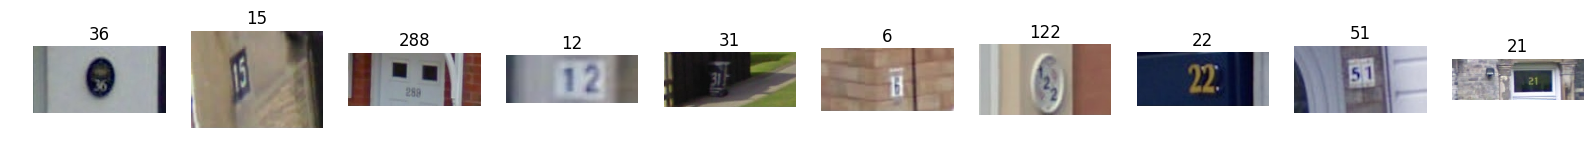

In [89]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = str(j+1)+'.png'
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[j,0]):
        house_num += str(test_labels[j,k+1])
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

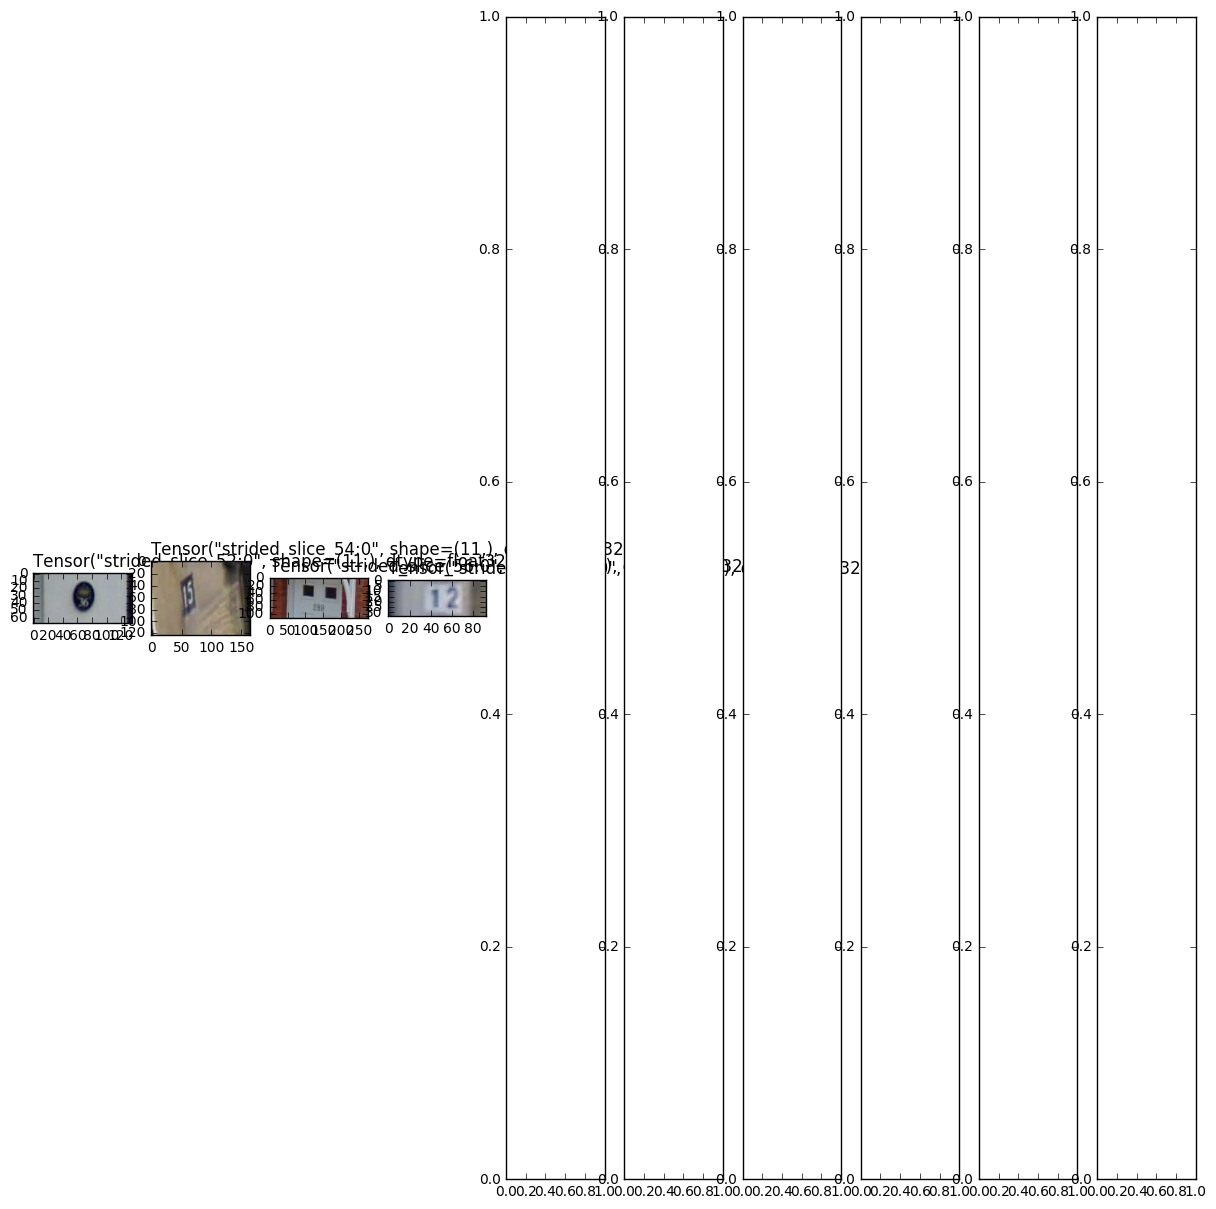

In [95]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)
im_samples = im_samples[:4]
for i, j in enumerate(im_samples):
    filename = str(j+1)+'.png'
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(np.sum(test_prediction[i,:] != 10)):
        house_num += str(test_prediction[i,k])

    ax[i].set_title(house_num, loc='left')
    ax[i].imshow(im)   

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

The training and testing dataset ommits a validation set due to computational weight
Also, the preprocessed data was not cleaned of overly long numbers due to computational weight

The original pictures have foremost been transferred to greyscale (1-channel) and normalized, shuffled to improve preconditions for training.
Possibly, the bounding box information per digit is not considered yet.


The model does not yet perform overly well, most likely, the number of digits and the actual position of the numbers within the image are not yet adequately considered.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.